# Visualizing Canonical View in Neural Image Representations

This is a script to visualize a learned canonical view in neural image representations.

In [1]:
%matplotlib inline
# 用于连接jupyter notebook

In [2]:
import os
os.getcwd()
os.chdir(r'G:\Image_Decomposition\nir-main-Ran')
os.getcwd()

'G:\\Image_Decomposition\\nir-main-Ran'

In [3]:
import numpy as np
from itertools import chain
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

from model import Siren, Homography
from util import get_mgrid, apply_homography, jacobian, VideoFitting

### Fitting with homography-based neural image representations

In [4]:
def train_homography(path, total_steps, verbose=True, steps_til_summary=100):
    transform = Compose([
        Resize(512),
        ToTensor(),
        Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
    ])
    v = VideoFitting(path, transform)
    videoloader = DataLoader(v, batch_size=1, pin_memory=True, num_workers=0)

    g = Homography(hidden_features=256, hidden_layers=2)
    g.cuda()
    f = Siren(in_features=2, out_features=3, hidden_features=256, 
              hidden_layers=4, outermost_linear=True)
    f.cuda()
    optim = torch.optim.Adam(lr=1e-4, params=chain(g.parameters(), f.parameters()))

    model_input, ground_truth = next(iter(videoloader))
    model_input, ground_truth = model_input[0].cuda(), ground_truth[0].cuda()

    batch_size = (v.H * v.W) // 4
    for step in range(total_steps):
        start = (step * batch_size) % len(model_input)
        end = min(start + batch_size, len(model_input))

        xy, t = model_input[start:end, :-1], model_input[start:end, [-1]]
        h = g(t)
        o = f(apply_homography(xy, h))
        loss = ((o - ground_truth[start:end]) ** 2).mean()

        if verbose and not step % steps_til_summary:
            print("Step [%04d/%04d]: loss=%0.4f" % (step, total_steps, loss))

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return f

In [5]:
f = train_homography('./data/vis/homography', 3000)

Step [0000/3000]: loss=0.3733
Step [0100/3000]: loss=0.0413
Step [0200/3000]: loss=0.0302
Step [0300/3000]: loss=0.0260
Step [0400/3000]: loss=0.0233
Step [0500/3000]: loss=0.0236
Step [0600/3000]: loss=0.0178
Step [0700/3000]: loss=0.0169
Step [0800/3000]: loss=0.0166
Step [0900/3000]: loss=0.0131
Step [1000/3000]: loss=0.0115
Step [1100/3000]: loss=0.0177
Step [1200/3000]: loss=0.0102
Step [1300/3000]: loss=0.0107
Step [1400/3000]: loss=0.0116
Step [1500/3000]: loss=0.0088
Step [1600/3000]: loss=0.0106
Step [1700/3000]: loss=0.0088
Step [1800/3000]: loss=0.0086
Step [1900/3000]: loss=0.0111
Step [2000/3000]: loss=0.0081
Step [2100/3000]: loss=0.0106
Step [2200/3000]: loss=0.0108
Step [2300/3000]: loss=0.0102
Step [2400/3000]: loss=0.0081
Step [2500/3000]: loss=0.0074
Step [2600/3000]: loss=0.0087
Step [2700/3000]: loss=0.0111
Step [2800/3000]: loss=0.0071
Step [2900/3000]: loss=0.0105


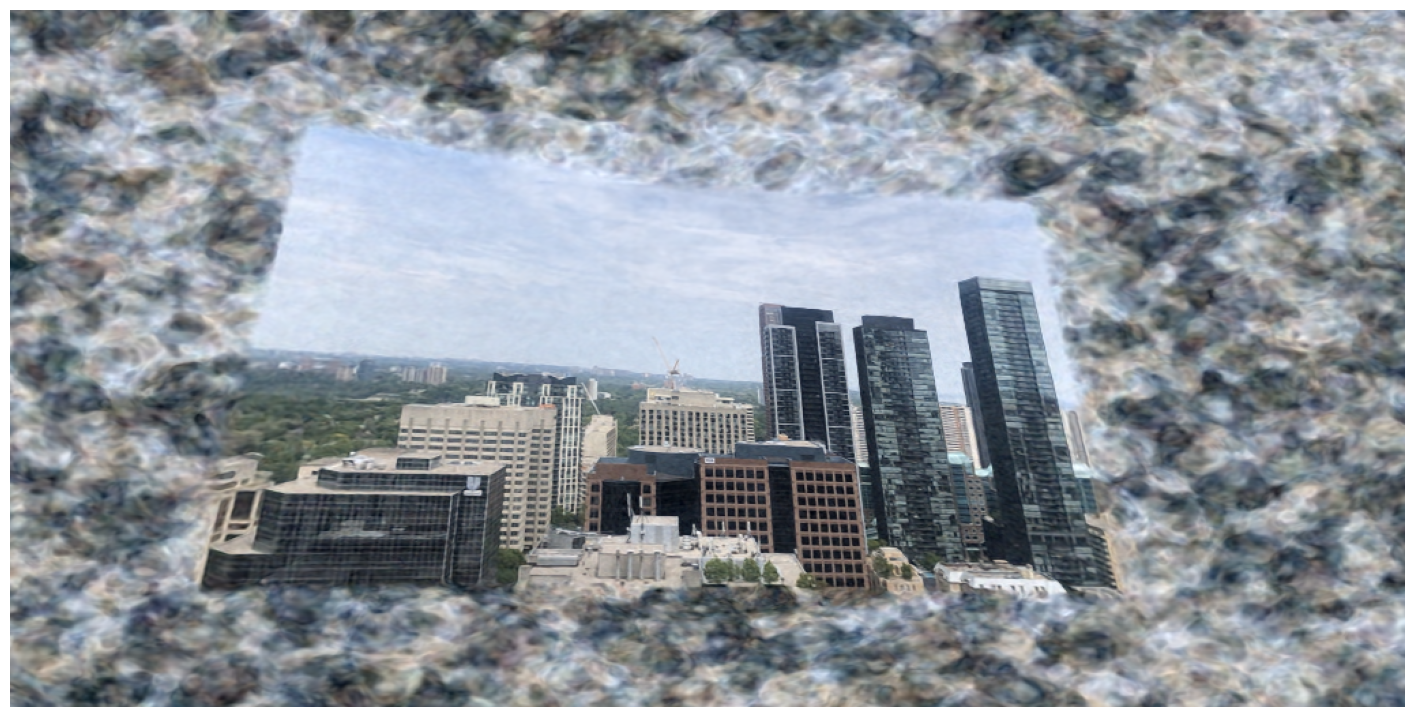

In [6]:
with torch.no_grad():
    xy = get_mgrid([512, 1024], [-1.5, -2.0], [1.5, 2.0]).cuda()
    output = f(xy)
    output = output.view(512, 1024, 3).cpu().detach().numpy()
    output = np.clip(output, -1, 1) * 0.5 + 0.5
fig, axes = plt.subplots(figsize=(18, 18))
axes.imshow(output)
plt.axis('off')
plt.show()

### Fitting with occlusion-aware flow-based neural image representations

In [7]:
def train_occlaware_flow(path, total_steps, lambda_flow=0.02, verbose=True, steps_til_summary=100):
    transform = Compose([
        Resize(512),
        ToTensor(),
        Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
    ])
    v = VideoFitting(path, transform)
    videoloader = DataLoader(v, batch_size=1, pin_memory=True, num_workers=0)

    g = Siren(in_features=3, out_features=3, hidden_features=256,
              hidden_layers=5, outermost_linear=True)
    g.cuda()
    f = Siren(in_features=3, out_features=3, hidden_features=256, 
              hidden_layers=5, outermost_linear=True)
    f.cuda()
    optim = torch.optim.Adam(lr=1e-4, params=chain(g.parameters(), f.parameters()))

    model_input, ground_truth = next(iter(videoloader))
    model_input, ground_truth = model_input[0].cuda(), ground_truth[0].cuda()

    batch_size = (v.H * v.W) // 32
    for step in range(total_steps):
        start = (step * batch_size) % len(model_input)
        end = min(start + batch_size, len(model_input))
        
        xyt = model_input[start:end].requires_grad_()
        h = g(xyt)
        xy_, w = xyt[:, :-1] + h[:, :-1], h[:, [-1]]
        o = f(torch.cat((xy_, w), -1))
        loss_recon = (o - ground_truth[start:end]).abs().mean()
        loss_flow = jacobian(h, xyt).abs().mean()
        loss = loss_recon + lambda_flow * loss_flow

        if verbose and not step % steps_til_summary:
            print("Step [%04d/%04d]: recon=%0.8f, flow=%0.4f" % (step, total_steps, loss_recon, loss_flow))

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return g, f

In [8]:
g, f = train_occlaware_flow('./data/vis/flow', 5000)

Step [0000/5000]: recon=0.40435487, flow=0.1391
Step [0100/5000]: recon=0.07104128, flow=0.1789
Step [0200/5000]: recon=0.06225190, flow=0.1564
Step [0300/5000]: recon=0.05450381, flow=0.1368
Step [0400/5000]: recon=0.04835550, flow=0.1176
Step [0500/5000]: recon=0.04682318, flow=0.1081
Step [0600/5000]: recon=0.04531235, flow=0.0969
Step [0700/5000]: recon=0.04483908, flow=0.0895
Step [0800/5000]: recon=0.04252752, flow=0.0842
Step [0900/5000]: recon=0.04015880, flow=0.0783
Step [1000/5000]: recon=0.04020828, flow=0.0758
Step [1100/5000]: recon=0.03944258, flow=0.0716
Step [1200/5000]: recon=0.03835282, flow=0.0671
Step [1300/5000]: recon=0.03684363, flow=0.0650
Step [1400/5000]: recon=0.03736074, flow=0.0652
Step [1500/5000]: recon=0.03625445, flow=0.0610
Step [1600/5000]: recon=0.03694656, flow=0.0590
Step [1700/5000]: recon=0.03563454, flow=0.0574
Step [1800/5000]: recon=0.03597567, flow=0.0549
Step [1900/5000]: recon=0.03596938, flow=0.0555
Step [2000/5000]: recon=0.03541669, flow

In [9]:
with torch.no_grad():
    xyt = get_mgrid([512, 512, 2], [-1.2, -1.2, -1.], [1.2, 1.2, 1.]).cuda()
    h = g(xyt)
    xyw = torch.cat((xyt[:, :-1], h[:, [-1]]), -1)
    o_canview = f(xyw)
    o_canview = o_canview.view(512, 512, 2, 3).permute(2, 0, 1, 3).cpu().detach().numpy()
    o_canview = np.clip(o_canview, -1, 1) * 0.5 + 0.5
    o_canview = (o_canview * 255).astype(np.uint8)
    o_canview = [o_canview[i] for i in range(len(o_canview))]

In [10]:
# Save out video
# ! pip install --user imageio imageio-ffmpeg
import imageio
fn = os.path.join('./data/vis/canview_occlaware_flow.mp4')
imageio.mimwrite(fn, o_canview, fps=1)

# Display video inline
from IPython.display import HTML
from base64 import b64encode
mp4 = open(fn, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=512 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
''')